# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Implementation-of-Needleman-Wunsch-algorithm" data-toc-modified-id="Implementation-of-Needleman-Wunsch-algorithm-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Implementation of Needleman Wunsch algorithm</a></div><div class="lev1 toc-item"><a href="#Implementation-of-a-random-number-generator-with-a-negative-binomial-distribution" data-toc-modified-id="Implementation-of-a-random-number-generator-with-a-negative-binomial-distribution-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Implementation of a random number generator with a negative binomial distribution</a></div>

In [1]:
import numpy as np
import scipy.stats as stats

# Graphics
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

# Magic function to make matplotlib inline;
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14


# Implementation of Needleman Wunsch algorithm

The algorithm below works but is a little incomplete. At the moment it will fail if there are multiple optimal alignments, but this could be easily solved by choosing one optimal alignment at random. Alternatively, I could modify it by presenting all possible alignments, but I started this morning and ran out of time. All work below is my own.

In [9]:
class needle:
    def __init__(self, a, b):
        """Initialize needle object"""
        self.a = ' ' + a
        self.b = ' ' + b
        self.m, self.x, self.g = 10, -1, -5
        self.make_mat()
        self.histories = {}
        
    def make_mat(self):
        """Initialize alignment matrix"""
        n, n2 = len(self.a), len(self.b)
        mat = np.zeros(shape=(n, n2))
        mat[:,0]= np.linspace(0, (n-1)*self.g, n)
        mat[0,:] = np.linspace(0, (n2-1)*self.g, n2)
        self.mat = mat

    def matcher(self, c1, c2):           
        """For a pair of coordinates, if the pair matches,
        figure out whether they should be aligned or not"""
        if self.a[c1] == self.b[c2]:
            return self.m
        else:
            return self.x
    
    def submat(self, c1, c2):
        """Returns a 2x2 submatrix"""
        smat = self.mat[c1-1:c1+1, c2-1:c2+1]
        return smat
    
    def next_square(self, c1, c2):
        """Fill in the next 2x2 square"""
        smat = self.submat(c1, c2)
        # (c1,c2)-1 -> (c1, c2) is a possible match
        s00 = smat[0, 0] + self.matcher(c1, c2)
        # other two are gaps
        s10 = smat[1, 0] + self.g
        s01 = smat[0, 1] + self.g
        
        array = np.array([s00, s10, s01])
        score = np.max(array)
        self.mat[c1, c2] = score
        self.histories[(c1, c2)] = np.where(array == score)[0]
    
    def fill_in(self):
        """Fill in the matrix"""
        for c1 in range(1, len(self.a)):
            for c2 in range(1, len(self.b)):
                self.next_square(c1, c2)

    def init_traceback(self):
        """Initialize the traceback parameters"""
        # coordinates of the maximum score(s)
        # note, np.where returns an x-coord array and a y-coord
        # array in a tuple if there is more than one entry
        c = np.where(np.max(self.mat[:,len(self.b)-1]) == self.mat)
        if len(c[0]) > 1:
            # there are multiple alignments
            print('uhoh')
        else:
            self.initial_coords = (c[0][0], c[1][0])
            begin = self.histories[self.initial_coords]
        
        self.begin = begin
        
    
    def trace(self, c1, c2, trace, Sa, Sb):
        """Figures out whether it is a gap or a mismatch or what"""
        if len(trace) == 1:
            if trace[0] == 0:
                return c1-1, c2-1, self.a[c1-1]+Sa, self.b[c1-1]+Sb
            if trace[0] == 1:
                return c1-1, c2, self.a[c1-1]+Sa, '-'+Sb
            else:
                return c1, c2 -1, '-'+Sa, self.b[c2-1]+Sb
        else:
            print('uhoh')
    
    def traceback(self):
        """
        Trace an alignment path.
        This function currently only works if there is a SINGLE
        allowable alignment...
        I could easily fix this by choosing a random alignment out of
        the multiple optimal ones
        """
        self.init_traceback()
        c = np.where(np.max(self.mat[:,len(self.b)-1]) == self.mat)
        c1_init = c[0][0]
        c2_init = c[1][0]
        C1, C2 = np.array([c1_init]), np.array([c2_init])
        F = True
        c1, c2 = c1_init, c2_init
        Sa = self.a[c1]
        Sb = self.b[c2]
        while F:
            if (c1, c2) not in self.histories.keys():
                F = False
                continue
            c1, c2, Sa, Sb = self.trace(c1, c2, self.histories[(c1, c2)], Sa, Sb)
            C1, C2 = np.append(C1, [c1]), np.append(C2, [c2])
        self.C1 = C1
        self.C2 = C2
    
    def draw_alignments(self):
        """Draw the alignment as a matrix of zeros and 1's"""
        self.m = np.zeros(shape=(len(self.a), len(self.b)))
        for coord in zip(self.C1, self.C2):
            self.m[coord[0], coord[1]] = 1
        print(self.m)

In [3]:
wunsch = needle('atcg', 'atc')
wunsch.fill_in()
wunsch.mat

array([[  0.,  -5., -10., -15.],
       [ -5.,  10.,   5.,   0.],
       [-10.,   5.,  20.,  15.],
       [-15.,   0.,  15.,  30.],
       [-20.,  -5.,  10.,  25.]])

Here, I perform the traceback, and then draw the alignment as a matrix of zeros and ones.

In [4]:
wunsch.traceback()
wunsch.draw_alignments()

[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  1.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  0.  0.]]


# Implementation of a random number generator with a negative binomial distribution

For this problem, I relied heavily on this [PDF](http://sas.uwaterloo.ca/~dlmcleis/s906/probsolutions.pdf), page 21.

A geometric random variable, $Y_N$ can be generated from a ``geom(p)`` distribution by using the generator:
$$
Y_i = \lfloor 1 + \frac{\log{u_i}}{\log{1-p}} \rfloor
$$

The PDF I used claims that the negative binomial distribution with parameters ``p`` and ``n`` can be generated by
calculating:
$$
r + \sum_i^r Y_i(p)
$$

However, when I compare my generator with the scipy generator, the functions are shifted and the correction that
matches the curves exactly is:
$$
\sum_i^r Y_i(p) - r
$$

In [5]:
# define parameters to use
n = 10
p = .1

In [6]:
def bernoulli_generator(p):
    """Given a probability `p`, returns a geometrically distributed variable"""
    u = np.random.random()
    return np.floor(1 + np.log(u)/np.log(1-p))

def neg_binom_generator(n, p):
    """Generates random numbers with a negative binomial distribution.
    The method used is to add `n` random bernoulli variables, then subtracts
    `n`."""
    return np.sum(np.array([bernoulli_generator(p) for i in range(n)])) - n

In [7]:
# make arrays for histograms
iters = 10**4
# my function
x = np.array([neg_binom_generator(n, p) for i in range(iters)])
# scipy function
y = np.array([stats.nbinom.rvs(n, p, size=1) for i in range(iters)])

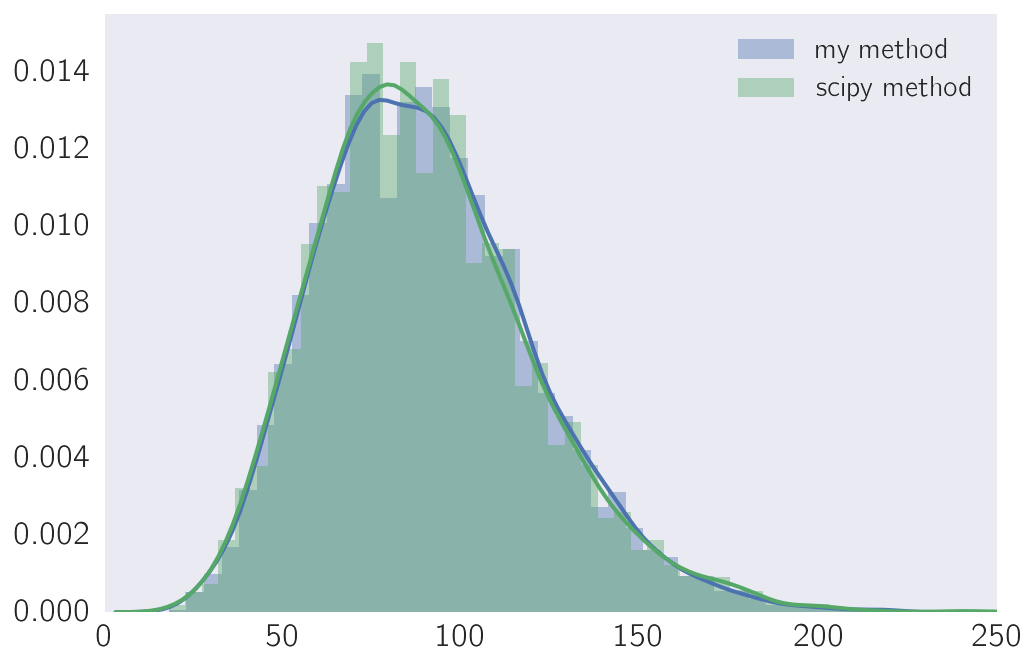

In [8]:
# plot
ax = sns.distplot(x, label='my method')
ax = sns.distplot(y, label='scipy method')
plt.xlim(0, 250)
plt.legend()